In [19]:
import ugradio
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic

In [81]:
def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

pwd = '../data/'
all_data = {}
for fins in ['on', 'off', 'cold', 'cal']:
    fname = f'{pwd}s_' + fins + '_3200.npy'
    all_data[fins] = np.load(fname)

freq_0 = 1420.4058e6 # Hz
num_samples = 2048 
samp_rate = 3.2e6 # Hz
c_speed = 299792458e-3 # km/s

In [5]:
def fft(data, num_samp=2048, samp_rate=3.2e6):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

In [23]:
def avg_power(dname):
    data = all_data[dname]
    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)
    return f, avg_pwr

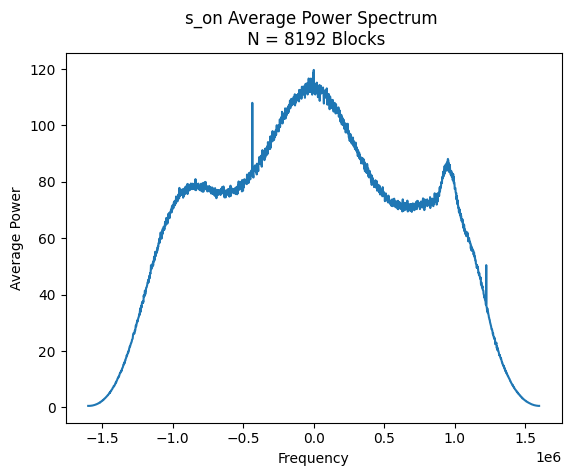

In [52]:
def plot_avg_power(dname):
    data = all_data[dname]
    num_blocks = data.shape[0]
    num_samples = data.shape[1]
    time = np.arange(data.shape[1]) * freq_to_period(samp_rate/10**3) # in microseconds

    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)

    # plot average power
    plt.figure()
    plt.plot(f, avg_pwr)
    plt.title('s_' + dname + ' Average Power Spectrum \n N = ' + str(num_blocks) + ' Blocks')
    plt.xlabel('Frequency')
    plt.ylabel('Average Power')
    plt.show()
plot_avg_power('on')

In [64]:
def freq_resolution(samp_rate, num_samples):
    result = samp_rate / num_samples
    print('frequency resolution = ' + str(result) + ' [units of samp_rate]')
    return result

freq_resolution(samp_rate, num_samples/1.25)

frequency resolution = 1953.125 [units of samp_rate]


1953.125

In [45]:
def adjust_freq_res(freqs, data, bins):
    bin_means, bin_edges, binnumber = binned_statistic(freqs, data, bins=bins)
    return bin_edges[:-1], bin_means

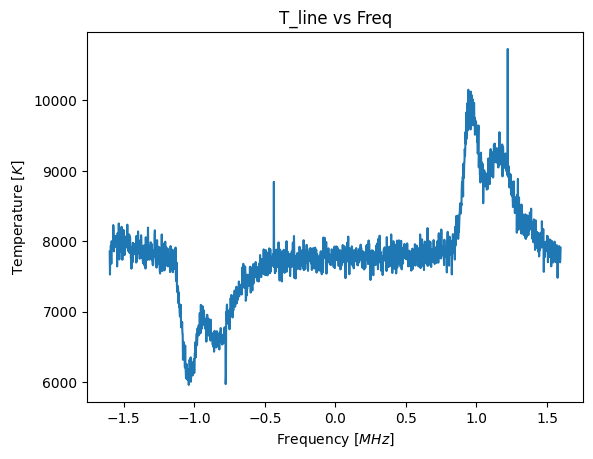

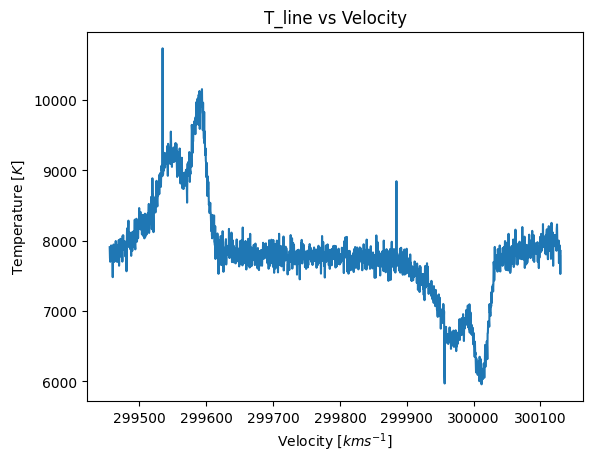

In [90]:
adj_data = {}
f_domain = []
adj_freq_res = num_samples/1.25
for fins in ['on', 'off', 'cold', 'cal']:
    data = all_data[fins]
    
    # average the power spectra of all blocks in data
    f, avg_pwr = avg_power(fins)
    
    # adjust frequency resolution to ~2 kHz
    adj_f, adj_pwr = adjust_freq_res(f, avg_pwr, adj_freq_res)
    
    # save data
    adj_data[fins] = adj_pwr
    f_domain = adj_f

s_on = adj_data['on']
s_off = adj_data['off']
s_cold = adj_data['cold']
s_cal = adj_data['cal']

# calc s_line
s_line = s_on / s_off

# calc G
T_syscal = 300
G = (T_syscal / np.sum(s_cal - s_cold)) * np.sum(s_cold)

# calc T_line
T_line = np.multiply(s_line, G)

# freq to velocity domain conversion
v_domain = - (f_domain - freq_0) * c_speed / freq_0

plt.plot(f_domain*10**-6, T_line, label='temp')
plt.title('T_line vs Freq')
plt.xlabel('Frequency [$MHz$]')
plt.ylabel('Temperature [$K$]')
plt.show()

plt.plot(v_domain, T_line, label='temp')
plt.title('T_line vs Velocity')
plt.xlabel('Velocity [$km s^{-1}$]')
plt.ylabel('Temperature [$K$]')
plt.show()